In [1]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
#hide
from fastbook import *
from kaggle import api
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 20


In [32]:
cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write(creds)
    cred_path.chmod(0o600)

In [33]:
path = URLs.path('bluebook')
path

Path('.')

In [34]:
#hide
Path.BASE_PATH = path

In [35]:
dep_var = 'SalePrice'

In [36]:
df_nn = pd.read_csv(path/'TrainAndValid.csv', low_memory=False)
df_nn['ProductSize'] = df_nn['ProductSize'].astype('category')
sizes = 'Large','Large / Medium','Medium','Small','Mini','Compact'
df_nn['ProductSize'].cat.set_categories(sizes, ordered=True, inplace=True)
df_nn[dep_var] = np.log(df_nn[dep_var])
df_nn = add_datepart(df_nn, 'saledate')

In [37]:
df_nn = df_nn.sample(350000, random_state=24)

In [38]:
len(df_nn)

350000

In [39]:
cond = (df_nn.saleYear<2011) | (df_nn.saleMonth<10)
train_idx = np.where( cond)[0]
valid_idx = np.where(~cond)[0]

splits = (list(train_idx),list(valid_idx))

In [40]:
df_nn_final = df_nn[["YearMade","ProductSize","Coupler_System","fiProductClassDesc","ModelID",
             "fiSecondaryDesc","fiModelDesc","Enclosure","Hydraulics_Flow","Hydraulics",
            "ProductGroup","Drive_System","Tire_Size", "saleElapsed"] + [dep_var]]

In [41]:
df_nn_final.columns

Index(['YearMade', 'ProductSize', 'Coupler_System', 'fiProductClassDesc',
       'ModelID', 'fiSecondaryDesc', 'fiModelDesc', 'Enclosure',
       'Hydraulics_Flow', 'Hydraulics', 'ProductGroup', 'Drive_System',
       'Tire_Size', 'saleElapsed', 'SalePrice'],
      dtype='object')

In [42]:
df_nn_final.head()

,YearMade,ProductSize,Coupler_System,fiProductClassDesc,ModelID,fiSecondaryDesc,fiModelDesc,Enclosure,Hydraulics_Flow,Hydraulics,ProductGroup,Drive_System,Tire_Size,saleElapsed,SalePrice
79557,1985,Small,NaN,"Hydraulic Excavator, Track - 12.0 to 14.0 Metric Tons",3385,NaN,205LC,EROPS,NaN,Standard,TEX,NaN,NaN,1.061510e+09,10.043249
268853,1000,NaN,None or Unspecified,Skid Steer Loader - 1251.0 to 1351.0 Lb Operating Capacity,9550,NaN,753,OROPS,Standard,Standard,SSL,NaN,NaN,1.118794e+09,9.047821
285996,2005,NaN,NaN,"Track Type Tractor, Dozer - 85.0 to 105.0 Horsepower",22352,K,850KWT,OROPS,NaN,2 Valve,TTT,NaN,NaN,1.190074e+09,10.915088
19873,2005,NaN,Yes,Skid Steer Loader - 1251.0 to 1351.0 Lb Operating Capacity,17309,NaN,S130,OROPS,High Flow,Auxiliary,SSL,NaN,NaN,1.286410e+09,9.047821
38726,1990,NaN,NaN,Wheel Loader - 120.0 to 135.0 Horsepower,6797,NaN,621,EROPS,NaN,2 Valve,WL,NaN,17.5,1.000858e+09,10.203592


In [43]:
cont_nn,cat_nn = cont_cat_split(df_nn_final, max_card=9000, dep_var=dep_var)

In [44]:
procs_nn = [Categorify, FillMissing, Normalize]
to_nn = TabularPandas(df_nn_final, procs_nn, cat_nn, cont_nn,
                      splits=splits, y_names=dep_var)

In [16]:
dls = to_nn.dataloaders(1024)

In [17]:
learn = tabular_learner(dls, y_range=(8,12), layers=[500,250],
                        n_out=1, loss_func=F.mse_loss)

SuggestedLRs(valley=0.00015848931798245758)

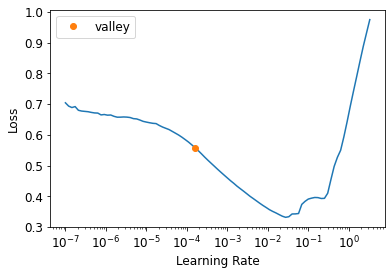

In [18]:
learn.lr_find()

In [19]:
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,time
0,0.064697,0.080445,00:03
1,0.056244,0.078426,00:03
2,0.049318,0.055939,00:03
3,0.043845,0.053740,00:03
4,0.040502,0.050680,00:03


In [22]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [21]:
preds,targs = learn.get_preds()
r_mse(preds,targs)

0.225122

In [22]:
get_emb_sz(learn.dls)

[(71, 17),
 (7, 5),
 (3, 3),
 (75, 18),
 (5089, 190),
 (173, 29),
 (4916, 187),
 (7, 5),
 (4, 3),
 (13, 7),
 (7, 5),
 (5, 4),
 (18, 8)]

In [23]:
df_nn_final.nunique()

YearMade                71
ProductSize              6
Coupler_System           2
fiProductClassDesc      74
ModelID               5128
fiSecondaryDesc        172
fiModelDesc           4915
Enclosure                6
Hydraulics_Flow          3
Hydraulics              12
ProductGroup             6
Drive_System             4
Tire_Size               17
saleElapsed           3983
SalePrice              913
dtype: int64

In [24]:
def getClassIdx(currGroup, target):
    for idx, val in enumerate(currGroup):
        if (val==target): 
            return idx
    return -1

In [25]:
df_embed = []
for index, row in df_nn_final.iterrows():
    row_embed = []
    emb_idx = 0
    for (colName, colData) in row.iteritems():
        if (colName=='saleElapsed' or colName=='SalePrice'):
            row_embed.extend([colData])
        elif(pd.isna(colData) or getClassIdx(learn.dls.classes[colName], colData)==-1):
            row_embed.extend(Tensor.cpu(learn.model.embeds[emb_idx].weight.mean(axis=0)).detach().numpy())
            emb_idx += 1
        else:
            row_embed.extend(Tensor.cpu(learn.model.embeds[emb_idx].
                                        weight[getClassIdx(learn.dls.classes[colName], colData)]).detach().numpy())
            emb_idx += 1

    df_embed.append(row_embed)

In [26]:
df_embed_final = pd.DataFrame(df_embed)

In [27]:
df_embed_final.to_pickle("dataAsEmbeddings.pkl")

In [11]:
df_embed_final = load_pickle("dataAsEmbeddings.pkl")

In [12]:
df_embed_final.head()

,0,1,2,3,4,5,6,7,8,9,...,473,474,475,476,477,478,479,480,481,482
0,0.210069,-0.256054,0.140934,0.015503,-0.203351,0.257414,0.067230,-0.107796,0.065374,0.045940,...,0.09220,0.029157,-0.042757,0.078990,0.048331,-0.069729,0.084349,0.041910,1.061510e+09,10.043249
1,0.022440,-0.472461,-0.118124,0.111385,-0.094318,-0.226030,0.071839,0.025880,0.158823,0.144774,...,0.09220,0.029157,-0.042757,0.078990,0.048331,-0.069729,0.084349,0.041910,1.118794e+09,9.047821
2,-0.019598,0.203523,-0.235036,-0.036901,0.200980,-0.149845,-0.242994,0.211987,-0.197601,-0.234967,...,0.09220,0.029157,-0.042757,0.078990,0.048331,-0.069729,0.084349,0.041910,1.190074e+09,10.915088
3,-0.019598,0.203523,-0.235036,-0.036901,0.200980,-0.149845,-0.242994,0.211987,-0.197601,-0.234967,...,0.09220,0.029157,-0.042757,0.078990,0.048331,-0.069729,0.084349,0.041910,1.286410e+09,9.047821
4,0.394319,-0.180132,0.383332,-0.127643,-0.207724,0.310899,0.004211,0.002595,0.004435,-0.095828,...,-0.03475,-0.353593,0.055611,-0.006158,0.027939,-0.214759,0.122818,0.114722,1.000858e+09,10.203592


In [13]:
#cols = df_embed_final.select_dtypes(exclude=['float']).columns
#df_embed_final[cols] = df_embed_final[cols].apply(pd.to_numeric, downcast='float', errors='coerce')

In [14]:
df_embed_final.shape

(350000, 483)

In [15]:
def rf(xs, y, n_estimators=40, max_samples=200_000,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [16]:
dep_var = 482

In [17]:
#df_embed_final = df_embed_final.fillna(0)

In [18]:
procs = [FillMissing]
cont,cat = cont_cat_split(df_embed_final, dep_var=dep_var)

In [19]:
embed_tab = TabularPandas(df_embed_final, procs, cat, cont, y_names=dep_var, splits=splits)

In [20]:
m = rf(embed_tab.train.xs, embed_tab.train.y)

In [23]:
m_rmse(m, embed_tab.train.xs, embed_tab.train.y), m_rmse(m, embed_tab.valid.xs, embed_tab.valid.y)

(0.175239, 0.226973)

In [27]:
dt = DecisionTreeRegressor(min_samples_leaf=25)
dt.fit(embed_tab.train.xs, embed_tab.train.y)
m_rmse(dt, embed_tab.train.xs, embed_tab.train.y), m_rmse(dt, embed_tab.valid.xs, embed_tab.valid.y)

(0.202033, 0.248385)

In [45]:
gb = GradientBoostingRegressor(min_samples_leaf=25)
gb.fit(to_nn.train.xs, to_nn.train.y)
m_rmse(gb, to_nn.train.xs, to_nn.train.y), m_rmse(gb, to_nn.valid.xs, to_nn.valid.y)

(0.306303, 0.315475)

In [30]:
gb = GradientBoostingRegressor(min_samples_leaf=25)
gb.fit(embed_tab.train.xs, embed_tab.train.y)
m_rmse(gb, embed_tab.train.xs, embed_tab.train.y), m_rmse(gb, embed_tab.valid.xs, embed_tab.valid.y)

(0.24827, 0.257786)

In [46]:
dls = embed_tab.dataloaders(1024)
learn = tabular_learner(dls, y_range=(8,12), layers=[500,250],
                        n_out=1, loss_func=F.mse_loss)
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,time
0,0.061023,0.062685,00:09
1,0.051124,0.056627,00:03
2,0.044885,0.051571,00:03
3,0.042067,0.051674,00:03
4,0.040275,0.051606,00:03


In [47]:
preds,targs = learn.get_preds()
r_mse(preds,targs)

0.22717